# Assignment : IDfy
- @Name : Subham Sarkar
- @Github : https://github.com/SubhamIO
- @LinkedIn : https://www.linkedin.com/in/subham-sarkar-4224aa147/
- @Portfolio : https://subhamio.github.io/SubhamSarkar-PortfolioWebsite/

# Title : Text Recognition from low quality License Plates using Deep Learning

## Objective:
- The objective of this assignment is to build an OCR solution for the provided dataset. This specific dataset is normal and HDR readings of license plates.

## Requirements:
1. Use an 80:20 train:test split on the provided dataset
2. Create a model for reading the text using any approaches or tools that you are familiar with
or can learn
3. Use the available test set to check the accuracy of your model

## Dataset:
1. The image dataset ​here​ contains 652 images of cropped license plates with a csv containing annotation as well.
- Link: https://medusa.fit.vutbr.cz/traffic/download/513/

## Load Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive/

/content/drive/My Drive


In [3]:
import re
import cv2 
import numpy as np

from matplotlib import pyplot as plt
import pandas as pd
from keras.preprocessing.image import *
from keras.layers.core import *
import tensorflow as tf
from keras.layers import *
from keras.models import *
import keras
from keras import backend as K
from keras.callbacks import *
np.random.seed(0)
from keras.utils.np_utils import to_categorical   
from keras.regularizers import l2
import seaborn as sns


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Acquisition

In [0]:
# base_dir = '/Users/subham/Desktop/2017-IWT4S-HDR_LP-dataset/'
base_dir = "./2017-IWT4S-HDR_LP-dataset/"

In [0]:
data = pd.read_csv("./2017-IWT4S-HDR_LP-dataset/" + "/trainVal.csv")

In [6]:
data.tail()

,track_id,image_path,lp,train
647,./crop_m4/I00084.png,./crop_h4/I00084.png,2B90178,0
648,./crop_m4/I00085.png,./crop_m4/I00085.png,7B59839,0
649,./crop_m4/I00085.png,./crop_h4/I00085.png,7B59839,0
650,./crop_m4/I00086.png,./crop_m4/I00086.png,7B11123,0
651,./crop_m4/I00086.png,./crop_h4/I00086.png,7B11123,0


In [17]:
n = data.shape[0]
print(n)

652


0    652
Name: train, dtype: int64


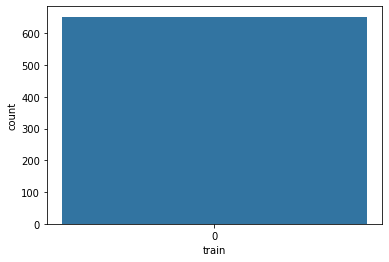

In [18]:
ax = sns.countplot(x=data['train'], data=data)
print(data['train'].value_counts())

## Observation :
- It has only test data as per README.txt provided

In [19]:
len(data['track_id'].unique())

326

In [20]:
len(data['image_path'].unique())

652

In [21]:
len(data['lp'].unique())

302

## Observation : 
- Unique track_id = 326
- Unique image_path = 652
- Many : 1 relationship [track_id : image_path]
- Unique lp = 302 , this means same images are present in different folders. So, not much variation in image types also the dataset is small. Accuracy will be impacted.

## Data Preprocessing

## Create a dictionary of length 37 [26 alphabets and 10 numbers and space] for target map

In [0]:
letters = " ABCDEFGHIJKLMNPQRSTUVWXYZ0123456789"
dic = {}
for i in range(len(letters)):
    dic[i] = letters[i]
invert_dic = {}
for i in range(len(letters)):
    invert_dic[letters[i]] = i

In [23]:
print(dic)

{0: ' ', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}


In [24]:
print(invert_dic)

{' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


In [0]:
X_train = []
y_train = []
X_test = []
y_test = []

## Creating X(feature)  , Y(target)


In [0]:
X = []
Y = []

In [0]:
for i in range(n): 
    temp_y= np.zeros((8)) # Target variable size = 8 dimensional
    path = base_dir + data["image_path"][i]
    # Read the images in gray scale
    temp_x = cv2.imread(base_dir + data["image_path"][i], cv2.IMREAD_GRAYSCALE)
    # Resizing as per our need to process in our CNN architecture
    temp_x = cv2.resize(temp_x,(256,64))
    X.append(temp_x)
    # Let's loop over each ground truth and assign each character with index
    for j,k in enumerate(data["lp"][i]):
        temp_y[j] = invert_dic[k] 

    Y.append(temp_y)    


In [28]:
len(X), len(Y)

(652, 652)

In [0]:
# import pickle

# with open('X_train', 'wb') as fp:
#     pickle.dump(X_train, fp)

In [0]:
# with open('X_test', 'wb') as fp:
#     pickle.dump(X_test, fp)

In [0]:
# with open('y_train', 'wb') as fp:
#     pickle.dump(y_train, fp)

In [0]:
# with open('y_test', 'wb') as fp:
#     pickle.dump(y_test, fp)

In [0]:
# with open ('y_test', 'rb') as fp:
#     y_test1 = pickle.load(fp)

## Let's look at the mapping created

In [30]:
data['lp'][0]

'9B52145'

__{' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}__

In [31]:
Y[0]

array([35.,  2., 31., 28., 27., 30., 31.,  0.])

## Train-Test Split (80:20)

In [32]:
ll = 0.8*len(X)
ll = int(ll)
X_train = X[:ll]
X_test = X[ll:]
y_train = Y[:ll]
y_test = Y[ll:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

521 521 131 131


In [0]:
# reshaping the array [-1 automatically adjust the number of data points here]
X_train = np.array(X_train).reshape(-1,64,256,1)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1,64,256,1)
y_test = np.array(y_test)

# Normalise the data
X_train = X_train /255
X_test = X_test/255

# converting target to_categorical (encoding the target characters to 36 dimensions)
y_test = to_categorical(y_test,36)
y_train = to_categorical(y_train,36)


In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(521, 64, 256, 1)
(521, 8, 36)
(131, 64, 256, 1)
(131, 8, 36)


In [0]:
print(y_train[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Data Modelling

# Let's define VGG-16 architecture
- Could have used transfer learning but VGG-16 takes (224,224,3) as input dimension
- So, better define the VGG-16 architecture from scratch , so that we can specify input dimensions manually.


In [0]:
def VGG(shape=(64, 256, 1),n_channels=64,weight_decay=0,batch_momentum=0.99):
    bn_axis = 3
    input_ = Input(shape=shape)
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input_)
    x = BatchNormalization(axis=bn_axis, name='bn00_x1', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn01_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn11_x1', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn12_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn21_x1', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn22_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
#    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3', kernel_initializer='glorot_uniform', kernel_regularizer=l2(weight_decay))(x)
#    x = BatchNormalization(axis=bn_axis, name='bn23_x3', momentum=batch_momentum)(x)
#    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn31_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn32_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
#    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3', kernel_initializer='glorot_uniform', kernel_regularizer=l2(weight_decay))(x)
#    x = BatchNormalization(axis=bn_axis, name='bn33_x2', momentum=batch_momentum)(x)
#    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn41_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
#    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2', kernel_initializer='glorot_uniform', kernel_regularizer=l2(weight_decay))(x)
#    x = BatchNormalization(axis=bn_axis, name='bn42_x2', momentum=batch_momentum)(x)
#    x = Activation('relu')(x)
    
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv3', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn43_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Conv2D(1024, (3, 3), padding='same', name='block6_conv1', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn51_x2', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(1024*2, (3, 3), padding='same', name='block6_conv12', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=bn_axis, name='bn51_x22', momentum=batch_momentum)(x)
    x = Activation('relu')(x)
    x= Dropout(0.3, noise_shape=None, seed=None)(x)
   
    
    #block5
   
    
    X = AveragePooling2D((2, 2), strides = (2, 1), name='avg_pool1',padding ='same')(x)
    X = Reshape((8,1024*2))(X)
    
    
    X = Conv1D(512, 3, strides=1, padding='same',name = 'conv1y'  ,activation=None,  dilation_rate=1,  use_bias=True, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.000))(X)
    X = BatchNormalization(axis = 2, name = 'bn01y')(X)
    X = Activation('relu')(X)
    X= Dropout(0.3, noise_shape=None, seed=None)(X)
    X = Conv1D(36, 1 , strides=1, padding='same',name = 'conv1x'  ,activation=None,  dilation_rate=1,  use_bias=True, kernel_initializer="he_normal")(X)
    X = BatchNormalization(axis = 2, name = 'bnhe')(X)
    X = Activation('softmax')(X)
    model = Model(inputs = [input_], outputs = [X])
    return model

In [0]:
model = VGG(shape=(64, 256, 1))

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 256, 1)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 256, 128)      1280      
_________________________________________________________________
bn00_x1 (BatchNormalization) (None, 64, 256, 128)      512       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 256, 128)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 256, 128)      147584    
_________________________________________________________________
bn01_x2 (BatchNormalization) (None, 64, 256, 128)      512       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 256, 128)      0   

## Defining custom metrics


In [0]:
def custom_loss(y_true, y_pred):
    s = K.shape(y_pred)
    y_true = K.reshape(y_true,(-1,s[-1]))
    y_pred = K.reshape(y_pred,(-1,s[-1]))
    loss = K.sum(keras.losses.categorical_crossentropy(y_true, y_pred))
    num = K.shape(y_true)[0]
    num=tf.cast(num,tf.float32)
    return K.mean(loss)/num

In [0]:
def metric1(y_true, y_pred):

    s = K.shape(y_pred)
    
    # reshape such that w and h dim are multiplied together
    y_true_reshaped = K.reshape( y_true,  (-1,s[-1]) )
    y_pred_reshaped = K.reshape( y_pred,  (-1, s[-1]) )

    # correctly classified
    clf_pred =  K.argmax(y_pred_reshaped,axis = -1)
    y_true = K.argmax(y_true_reshaped,axis = -1)
    correct_pixels_per_class = K.cast( K.equal(clf_pred,y_true), dtype='float32') #if equal

    return K.sum(correct_pixels_per_class) / K.cast(K.prod(s[:-1]), dtype='float32') #accuracy

In [0]:
def metric2(y_true, y_pred):

    s = K.shape(y_pred)

    # correctly classified
    clf_pred =  K.argmax(y_pred,axis = -1)
    y_true = K.argmax(y_true,axis = -1)
    correct_pixels_per_class = K.cast(K.all( K.equal(clf_pred,y_true),axis=-1), dtype='float32') #if equal

    return K.sum(correct_pixels_per_class) / K.cast(K.prod(s[0]), dtype='float32') #accuracy

In [0]:
model.compile(loss = custom_loss,optimizer='adam',metrics=[metric1,metric2])

In [0]:
model.load_weights("idfy1.h5")

## Training

In [0]:
datagen = ImageDataGenerator(width_shift_range=0.14,
                                 height_shift_range=0.08,
                                 fill_mode='constant',
                                 zoom_range = 0.1,
                                 rotation_range = 10,
                                 #rescale  =1./255
                                 )

mcp_save = ModelCheckpoint('idfy1.h5', save_best_only=True, monitor='val_loss', mode='min',verbose=1)

def scheduler(epoch):
    if epoch <3 :
        return 0.001/5
    elif epoch < 10:
        return 0.001/10
    elif epoch < 15:
        return  0.00001
    elif epoch <30:
        return  0.00001/2
    
n = X_train.shape[0] 

lr_reduce = LearningRateScheduler(scheduler,verbose = 1)

history = model.fit_generator(datagen.flow(X_train, y_train,batch_size=64),
                         epochs = 30,
                         steps_per_epoch=n//64,
                         callbacks=[lr_reduce,mcp_save],
                         validation_data=(X_test, y_test)) 

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002.
8/8 [==============================] - 12s 2s/step - loss: 0.5540 - metric1: 0.9953 - metric2: 0.9705 - val_loss: 1.0427 - val_metric1: 0.9232 - val_metric2: 0.7448

Epoch 00001: val_loss improved from inf to 1.04265, saving model to idfy1.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002.
8/8 [==============================] - 13s 2s/step - loss: 0.5444 - metric1: 0.9980 - metric2: 0.9844 - val_loss: 1.0200 - val_metric1: 0.9034 - val_metric2: 0.6128

Epoch 00002: val_loss improved from 1.04265 to 1.02004, saving model to idfy1.h5
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.0002.
8/8 [==============================] - 12s 1s/step - loss: 0.5748 - metric1: 0.9939 - metric2: 0.9648 - val_loss: 1.0594 - val_metric1: 0.9147 - val_metric2: 0.7031

Epoch 00003: val_loss did not improve from 1.02004
Epoch 4/30

Epoch 00004: LearningRateScheduler settin

## Utility funtion for plotting

In [0]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
nb_epoch=30

In [49]:
%matplotlib inline
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)


Test accuracy: 0.9041666984558105


## Test Accuracy : 90%

## Let's test on test data if it works good !!

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
n = X_test.shape[0]
count = 0
pred = model.predict(X_test)
pred = np.argmax(pred,axis=-1)
true = np.argmax(y_test,axis = -1)
for i in range(n):
    if np.all(pred[i,:]==true[i]):
        count +=1
print(count/n)

0.6335877862595419


## It gave me accurate results upto 63.4% . Thats great for this small dataset


['5', 'B', '2', '9', '6', '7', '0', ' ']


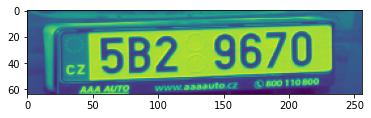

In [40]:
k = random.randint(0,100)  
imgplot = plt.imshow(X_test[k,:,:,:].reshape(64,256))  
arr = []
for i in range(8):
   arr.append(dic[pred[k,i]])
print(arr)

['7', 'B', '1', '4', '1', '5', '6', ' ']


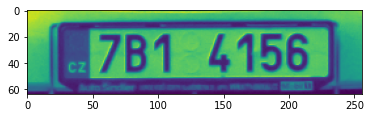

In [42]:
k = random.randint(0,100) 
imgplot = plt.imshow(X_test[k,:,:,:].reshape(64,256))  
arr = []
for i in range(8):
   arr.append(dic[pred[k,i]])
print(arr)

['4', 'A', 'X', '7', '9', '6', '2', ' ']


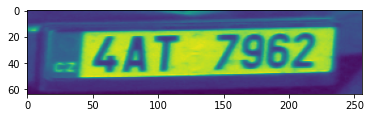

In [41]:
k = random.randint(0,100)  
imgplot = plt.imshow(X_test[k,:,:,:].reshape(64,256))  
arr = []
for i in range(8):
   arr.append(dic[pred[k,i]])
print(arr)

['7', 'B', '3', '1', '5', '0', '5', ' ']


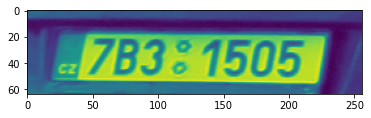

In [44]:
k = random.randint(0,100)  
imgplot = plt.imshow(X_test[k,:,:,:].reshape(64,256))  
arr = []
for i in range(8):
   arr.append(dic[pred[k,i]])
print(arr)

['9', 'B', '4', '6', '9', '8', '8', ' ']


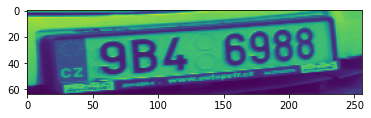

In [51]:
k = random.randint(0,100) 
imgplot = plt.imshow(X_test[k,:,:,:].reshape(64,256))  
arr = []
for i in range(8):
   arr.append(dic[pred[k,i]])
print(arr)

['7', 'B', '0', '8', '1', '9', '9', ' ']


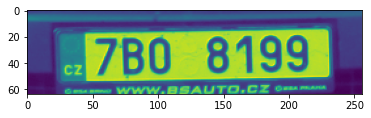

In [53]:
k = random.randint(0,100) 
imgplot = plt.imshow(X_test[k,:,:,:].reshape(64,256))  
arr = []
for i in range(8):
   arr.append(dic[pred[k,i]])
print(arr)

## Conclusion : 
- Test Accuracy - 90%
- Even this first cut solution gave tremendous results.
- The dataset was very small so, it had very less training data .
- Need to modify CNN architecture and need more data for better accuracy.
- Modifications : YOLO V3 for text detection would have given better results as per different research papers.


